# QRT ENS Data Challenge 2023 - Benchmark (english)

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [2]:
# Enable autoreload
%load_ext autoreload
%autoreload 2


# Regular imports
import  numpy as np
import  pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import  matplotlib.pyplot as plt
import os

from supp_material.utils import save_results_to_csv
from supp_material.preprocessing import data_preprocessing
from supp_material.xgboost_model import launch_xgb



## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [5]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [4]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [5]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Model and train score

The benchark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [6]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

Spearman correlation for the train set: 27.9%


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

## Generate the benchmark output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [7]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [8]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)


Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 


Run an XGBoost model as an alternative benchmark

#Preprocess the dataset

In [17]:
# Preprocess datasets


print("Preprocessing training data...")
X_train_processed, X_test_processed = data_preprocessing(X_train = X_train,Y_train=Y_train, X_test = X_test)
print(len(X_train_processed))
#X_train_processed.head()


Preprocessing training data...
Filled 0 rows. Remaining missing COUNTRY: 0
Filled 0 rows. Remaining missing COUNTRY: 0
1494


Create interaction constraints between countries

In [27]:
from supp_material.xgboost_model import create_country_interaction_constraints

interaction_constraints=create_country_interaction_constraints(X_train_processed.columns)
interaction_constraints


[Index(['DE_CONSUMPTION', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'DE_GAS', 'DE_COAL',
        'DE_HYDRO', 'DE_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'DE_LIGNITE',
        'DE_RESIDUAL_LOAD', 'DE_RAIN', 'DE_WIND', 'DE_TEMP',
        'is_market_decupled'],
       dtype='object'),
 Index(['FR_CONSUMPTION', 'FR_NET_EXPORT', 'FR_NET_IMPORT', 'FR_GAS', 'FR_COAL',
        'FR_HYDRO', 'FR_NUCLEAR', 'FR_SOLAR', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD',
        'FR_RAIN', 'FR_WIND', 'FR_TEMP'],
       dtype='object')]

In [18]:


predictions = launch_xgb(
    X_train=X_train_processed,
    y_train=Y_train['TARGET'],
    X_test=X_test_processed,
    run_test=True,
    task_type='regression',  # or 'classification'
    cv_folds=5,
    #params_constrained=interaction_constraints
)



Starting XGBoost Model Training Pipeline...
------------------------------------------------------------
Starting 5-fold cross-validation...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


ValueError: 
All the 480 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                             ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'object'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/sklearn.py", line 1340, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ~~~~~~~~~~~~~~~~~~~~~~~~~^
        missing=self.missing,
        ^^^^^^^^^^^^^^^^^^^^^
    ...<14 lines>...
        feature_types=feature_types,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/sklearn.py", line 701, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
        data=X,
    ...<9 lines>...
        ref=None,
    )
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/sklearn.py", line 1254, in _create_dmatrix
    return QuantileDMatrix(
        **kwargs, ref=ref, nthread=self.n_jobs, max_bin=self.max_bin
    )
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 1768, in __init__
    self._init(
    ~~~~~~~~~~^
        data,
        ^^^^^
    ...<12 lines>...
        max_quantile_blocks=max_quantile_batches,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 1832, in _init
    it.reraise()
    ~~~~~~~~~~^^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 617, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 598, in _handle_exception
    return fn()
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 685, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
                                              ~~~~~~~~~^^^^^^^^^^^^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/data.py", line 1632, in next
    input_data(**self.kwargs)
    ~~~~~~~~~~^^^^^^^^^^^^^^^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 774, in inner_f
    return func(**kwargs)
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/core.py", line 665, in input_data
    new, feature_names, feature_types = _proxy_transform(
                                        ~~~~~~~~~~~~~~~~^
        data,
        ^^^^^
    ...<2 lines>...
        self._enable_categorical,
        ^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/data.py", line 1685, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ~~~~~~~~~~~~~~~~~~~~^
        data, enable_categorical, feature_names, feature_types
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/data.py", line 662, in _transform_pandas_df
    feature_names, feature_types = pandas_feature_info(
                                   ~~~~~~~~~~~~~~~~~~~^
        data, meta, feature_names, feature_types, enable_categorical
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/data.py", line 409, in pandas_feature_info
    _invalid_dataframe_dtype(data)
    ~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/xgboost/data.py", line 372, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:COUNTRY: object


Save the results in a csv file

In [39]:
save_results_to_csv(dataset_wit_IDs = X_test, predictions= predictions, file_name='xgb_test_performances')

IDs length: 654, Predictions length: 654
True
Saved predictions to `./xgb_test_performances_20251117_130534.csv`


Run TabPFN


In [20]:

from tabpfn import TabPFNRegressor

from sklearn.model_selection import train_test_split
from tabpfn.constants import ModelVersion
# Split indices to keep alignment
X_80_train, X_20_test, y_80_train, y_20_test = train_test_split(
    X_train_processed, Y_train, test_size=0.2, random_state=41, shuffle=True
)

#test performances
regressor_train = TabPFNRegressor()  # Uses TabPFN-2.5 weights, trained on synthetic data only.

regressor_train = TabPFNRegressor.create_default_for_version(ModelVersion.V2)


# To use TabPFN v2:
# regressor = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
regressor_train.fit(X_80_train, y_80_train['TARGET'])

# Predict on the test set
predictions_train = regressor_train.predict(X_20_test)

holdout_spear = spearmanr(y_20_test['TARGET'], predictions_train).correlation
print(f"Spearman correlation on the holdout set: { holdout_spear:.4f}")



regressor = TabPFNRegressor()  # Uses TabPFN-2.5 weights, trained on synthetic data only.
# To use TabPFN v2:
# regressor = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
regressor.fit(X_train_processed, Y_train['TARGET'])

# Predict on the test set
predictions = regressor.predict(X_test_processed)

# Save the results in a csv file
save_results_to_csv(dataset_wit_IDs = X_test, predictions= predictions, file_name='tabpfn_test_performances')

Spearman correlation on the holdout set: 0.2464
IDs length: 654, Predictions length: 654
True
Saved predictions to `./tabpfn_test_performances_20251117_142217.csv`


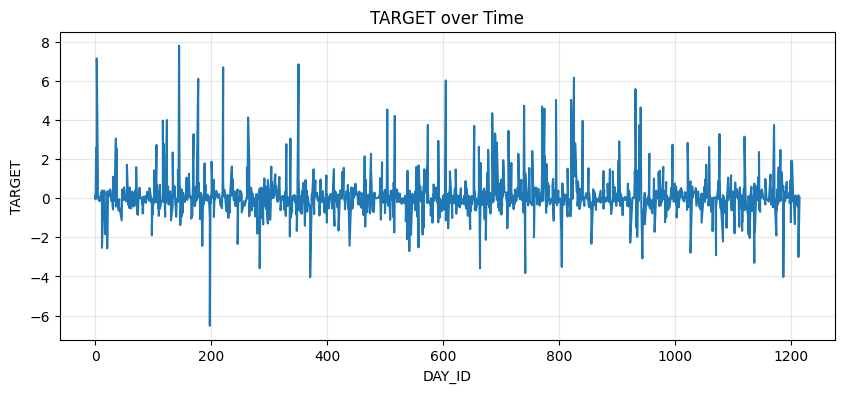

In [18]:
# analyze the data ti check if they are ordered in time


import matplotlib.pyplot as plt

# Load your data
X_train = pd.read_csv("X_train.csv")
Y_train = pd.read_csv("Y_train.csv")

# Merge and sort
df = X_train.merge(Y_train, on="ID").sort_values("DAY_ID")

# Plot
df.plot(x="DAY_ID", y="TARGET", figsize=(10, 4), title="TARGET over Time", legend=False)
plt.xlabel("DAY_ID")
plt.ylabel("TARGET")
plt.grid(True, alpha=0.3)



Number of unique DAY_ID values: 851
742          NaN
1211         NaN
1408         NaN
1468   -1.714706
329          NaN
          ...   
1007         NaN
986     0.281154
1465         NaN
873    -3.151575
1437         NaN
Name: TARGET, Length: 1494, dtype: float64


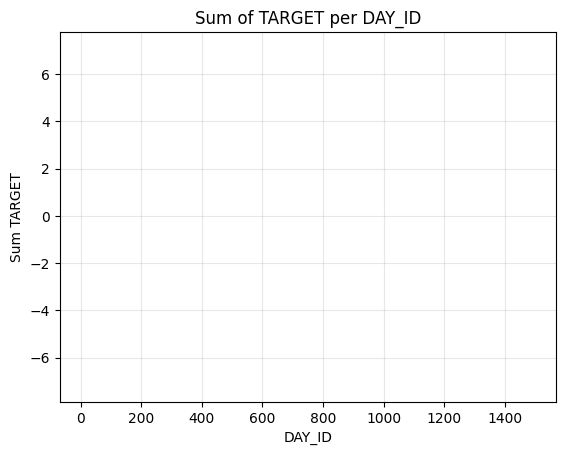

In [26]:

merged = X_train.merge(Y_train, on="ID").sort_values("DAY_ID")

unique_days = merged["DAY_ID"].nunique()
print("Number of unique DAY_ID values:", unique_days)


agg = merged.groupby("DAY_ID", as_index=False)["TARGET"].diff()

agg.plot(x="DAY_ID", y="TARGET", title="Sum of TARGET per DAY_ID", legend=False)
plt.xlabel("DAY_ID")
plt.ylabel("Sum TARGET")
plt.grid(alpha=0.3)



In [22]:

df= X_test.copy()
# df has columns: ID, DAY_ID, COUNTRY (values 'FR'/'DE' or NaN)
mask_na = df["COUNTRY"].isna()

# For each DAY_ID, get the single known country if (and only if) there's exactly one unique known value
known = df.groupby("DAY_ID")["COUNTRY"].transform(
        lambda s: s.dropna().unique()[0] if s.dropna().nunique() == 1 else np.nan
)

# Map to the opposite country
opp = known.map({"FR": "DE", "DE": "FR"})

# Fill only where COUNTRY is NaN and we have a determinate opposite
to_fill = mask_na & opp.notna()
df.loc[to_fill, "COUNTRY"] = opp[to_fill].values

# (Optional) report what was filled and what remains missing
filled_rows = df.loc[to_fill, ["ID", "DAY_ID", "COUNTRY"]]
remaining_missing = df["COUNTRY"].isna().sum()
print(f"Filled {to_fill.sum()} rows. Remaining missing COUNTRY: {remaining_missing}")
# If you want to see which DAY_IDs were filled:
# print(filled_rows.sort_values('DAY_ID'))

df.head()

Filled 0 rows. Remaining missing COUNTRY: 0


,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


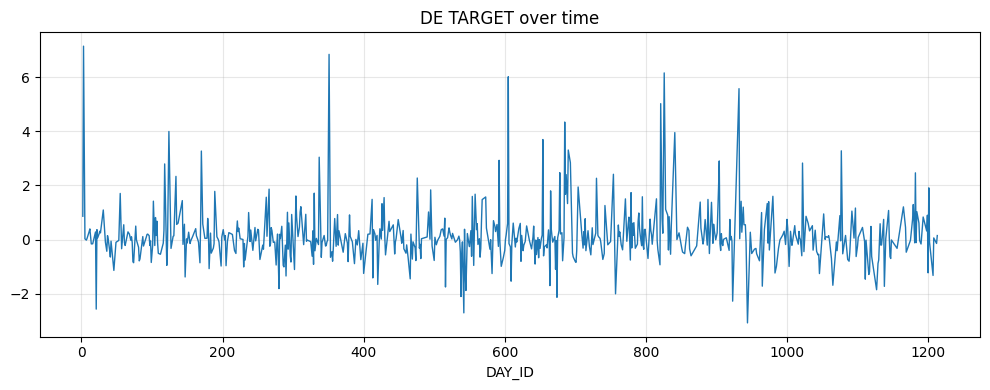

Non-seasonal AIC: 1849.5
Weekly-seasonal AIC (s=7): 1830.8
Seasonality evidence: YES (s=7 better)


/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/popcorn/PycharmProjects/QRT_energy/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/popcorn/PycharmProjects/QRT_energy/venv/li

In [29]:


import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


df = X_train.merge(Y_train, on="ID").sort_values("DAY_ID")
df = df[df["COUNTRY"] == "DE"]

# one value per day (in case duplicates exist)
y = df.groupby("DAY_ID")["TARGET"].mean().sort_index()



# --- plot TARGET ---
y.plot(figsize=(10,4), title="DE TARGET over time", lw=1)
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# --- ARIMA (no seasonality) vs SARIMA (weekly seasonality s=7) ---
m0 = SARIMAX(y, order=(1,0,1), seasonal_order=(0,0,0,0),
             enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
m7 = SARIMAX(y, order=(1,0,1), seasonal_order=(1,0,1,7),
             enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

print(f"Non-seasonal AIC: {m0.aic:.1f}")
print(f"Weekly-seasonal AIC (s=7): {m7.aic:.1f}")
print("Seasonality evidence:", "YES (s=7 better)" if m7.aic < m0.aic else "NO (no improvement)")

